<a href="https://colab.research.google.com/github/Pranav0771/EE708/blob/main/Final_Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install albumentations

In [ ]:
# Importing Libraries

import os
import shutil
import gzip
import tarfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
import albumentations as A
from albumentations.pytorch import ToTensorV2
from google.colab import drive

In [ ]:
drive.mount('/content/drive')
files = os.listdir('/content/drive/My Drive/kvasir-capsule/labelled_images')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
output_folder = '/content/unzipped'
os.makedirs(output_folder, exist_ok=True)

gz_folder = '/content/drive/My Drive/kvasir-capsule/labelled_images'

for file_name in os.listdir(gz_folder):
    if file_name.endswith('.tar.gz'):
        gz_path = os.path.join(gz_folder, file_name)
        tar_path = os.path.join(output_folder, file_name[:-3])  # Removes .gz

        with gzip.open(gz_path, 'rb') as f_in:
            with open(tar_path, 'wb') as f_out:
                shutil.copyfileobj(f_in, f_out)

        with tarfile.open(tar_path) as tar:
            tar.extractall(path=output_folder)
        os.remove(tar_path)

In [ ]:

shutil.rmtree('unzipped/Ampulla of vater')
shutil.rmtree('unzipped/Ileocecal valve')
shutil.rmtree('unzipped/Pylorus')

# removing anatomical data from meta data
metadata_path = "/content/metadata.csv"
df = pd.read_csv(metadata_path, sep=';')
df = df.loc[df['finding_category'] != "Anatomy"]

df.to_csv("new_meta.csv", index=False)


In [ ]:
# Path setup
image_root_dir = "/content/unzipped"  # e.g., /dataset/images/
metadata_path = "/content/new_meta.csv"   # your actual CSV with info

# Load the metadata CSV
df_meta = pd.read_csv(metadata_path, sep=',')

df_meta.columns = [
    'filename', 'video_id', 'frame_number',
    'anatomical_location', 'disease_class',
    'x1', 'y1', 'x2', 'y2', 'x3', 'y3', 'x4', 'y4'
]


df_meta['x_min'] = df_meta[['x1', 'x2', 'x3', 'x4']].min(axis=1)
df_meta['x_max'] = df_meta[['x1', 'x2', 'x3', 'x4']].max(axis=1)
df_meta['y_min'] = df_meta[['y1', 'y2', 'y3', 'y4']].min(axis=1)
df_meta['y_max'] = df_meta[['y1', 'y2', 'y3', 'y4']].max(axis=1)


df_diseased = df_meta[['filename', 'disease_class', 'x_min', 'y_min', 'x_max', 'y_max']]
df_diseased['class_label'] = df_diseased['disease_class']


all_images = []
for class_name in os.listdir(image_root_dir):
    class_dir = os.path.join(image_root_dir, class_name)
    for fname in os.listdir(class_dir):
        all_images.append((fname, class_name))

df_all = pd.DataFrame(all_images, columns=['filename', 'class_label'])


df_merged = df_all.merge(df_diseased, on='filename', how='left', suffixes=('', '_meta'))


for coord in ['x_min', 'y_min', 'x_max', 'y_max']:
    df_merged[coord] = df_merged[coord].fillna(0).astype(int)


df_merged['class_label'] = df_merged['disease_class'].fillna(df_merged['class_label'])


df_merged = df_merged[['filename', 'class_label', 'x_min', 'y_min', 'x_max', 'y_max']]


df_merged.to_csv("processed_kvasir_data.csv", index=False)

<ipython-input-13-599102122654>:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_diseased['class_label'] = df_diseased['disease_class']


In [ ]:
class KvasirDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform

        self.non_disease_label = 'Normal clean mucosa'  # Set this according to your CSV
        self.label2idx = {label: idx for idx, label in enumerate(sorted(self.data['class_label'].unique()))}

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        img_path = os.path.join(self.image_dir, row['class_label'], row['filename'])
        image = np.array(Image.open(img_path).convert("RGB"))

        class_label = row['class_label']
        label = self.label2idx[class_label]

        height, width = image.shape[:2]

        # If diseased, use bbox
        if class_label != self.non_disease_label:
            x_min, y_min = row['x_min'], row['y_min']
            x_max, y_max = row['x_max'], row['y_max']

            # Check if the bbox is valid (x_max > x_min and y_max > y_min)
            if x_max > x_min and y_max > y_min:
                # Normalize bbox coordinates to [0, 1]
                normalized_bbox = [
                    x_min / width,
                    y_min / height,
                    x_max / width,
                    y_max / height
                ]
                bboxes = [normalized_bbox]
                class_labels = [label]
            else:
                bboxes = []
                class_labels = []
        else:
            bboxes = []
            class_labels = []

        # Apply transformations
        if self.transform:
            if bboxes:
                transformed = self.transform(
                    image=image,
                    bboxes=bboxes,
                    class_labels=class_labels
                )
                image = transformed['image']
                bbox = torch.tensor(transformed['bboxes'][0], dtype=torch.float32) if transformed['bboxes'] else torch.tensor([0., 0., 0., 0.], dtype=torch.float32)
            else:
                transformed = self.transform(image=image, bboxes=[], class_labels=[])
                image = transformed['image']
                bbox = torch.tensor([0., 0., 0., 0.], dtype=torch.float32)
        else:
            image = transforms.ToTensor()(image)
            if class_label != self.non_disease_label:
                bbox = torch.tensor([x_min, y_min, x_max, y_max], dtype=torch.float32)
            else:
                bbox = torch.tensor([0., 0., 0., 0.])

        return image, label, bbox


    def plot_sample_with_box(self, idx):
        image_tensor, class_label, bbox_tensor = self[idx]


        img = image_tensor.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  # normalize to [0,1]

        fig, ax = plt.subplots(1)
        ax.imshow(img)

        print(bbox_tensor, type(bbox_tensor))

        x_min, y_min, x_max, y_max = bbox_tensor.tolist()
        width = x_max - x_min
        height = y_max - y_min

        rect = patches.Rectangle(
            (x_min, y_min), width, height,
            linewidth=1, edgecolor='red', facecolor='none'
        )
        ax.add_patch(rect)
        ax.set_title(f"Sample {idx} - Label: {class_label}")
        plt.axis('off')
        plt.show()


In [ ]:

def get_train_transform():
    return A.Compose([
        A.Resize(224, 224),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Normalize(),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def get_val_transform():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

def get_test_transform():
    return A.Compose([
        A.Resize(224, 224),
        A.Normalize(),
        ToTensorV2()
    ], bbox_params=A.BboxParams(format='pascal_voc', label_fields=['class_labels']))

In [ ]:

data = pd.read_csv("processed_kvasir_data.csv")


train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

# Save these to new CSVs
train_data.to_csv("train_kvasir_data.csv", index=False)
test_data.to_csv("test_kvasir_data.csv", index=False)

In [ ]:
# Datasets
train_dataset = KvasirDataset("train_kvasir_data.csv", "/content/unzipped", transform=get_train_transform())
test_dataset = KvasirDataset("test_kvasir_data.csv", "/content/unzipped", transform=get_test_transform())

/usr/local/lib/python3.11/dist-packages/albumentations/core/validation.py:87: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


tensor([0., 0., 0., 0.]) <class 'torch.Tensor'>


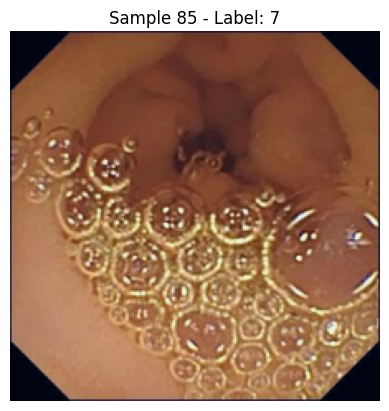

['Angiectasia' 'Normal clean mucosa' 'Ulcer' 'Foreign Body'
 'Reduced Mucosal View' 'Lymphangiectasia' 'Erythema' 'Erosion'
 'Blood - fresh' 'Polyp' 'Blood - hematin']
{'Angiectasia': 0, 'Blood - fresh': 1, 'Blood - hematin': 2, 'Erosion': 3, 'Erythema': 4, 'Foreign Body': 5, 'Lymphangiectasia': 6, 'Normal clean mucosa': 7, 'Polyp': 8, 'Reduced Mucosal View': 9, 'Ulcer': 10}


In [ ]:
train_dataset.plot_sample_with_box(85)
print(train_dataset.data['class_label'].unique())
print(train_dataset.label2idx)

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [ ]:
import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision.ops import generalized_box_iou_loss, box_iou

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IMAGE_SIZE = 224


class DualHeadResNet(nn.Module):
    def __init__(self, num_classes):
        super(DualHeadResNet, self).__init__()
        self.backbone = resnet18(pretrained=True)
        in_features = self.backbone.fc.in_features
        self.backbone.fc = nn.Identity()


        self.classifier = nn.Linear(in_features, num_classes)

        # Bounding box head (MLP)
        self.bbox_regressor = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 4)
        )

    def forward(self, x):
        features = self.backbone(x)
        class_logits = self.classifier(features)
        bbox_coords = self.bbox_regressor(features)
        return class_logits, bbox_coords

# Helper to fix box format to (x1, y1, x2, y2)
def fix_box_format(boxes):
    x1 = torch.min(boxes[:, 0], boxes[:, 2])
    y1 = torch.min(boxes[:, 1], boxes[:, 3])
    x2 = torch.max(boxes[:, 0], boxes[:, 2])
    y2 = torch.max(boxes[:, 1], boxes[:, 3])
    return torch.stack([x1, y1, x2, y2], dim=1)

num_classes = len(train_dataset.label2idx)
model = DualHeadResNet(num_classes).to(device)

criterion_cls = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


EPOCHS = 5
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0
    total_cls_loss = 0
    total_bbox_loss = 0

    for images, labels, bboxes in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        bboxes = bboxes.to(device)

        optimizer.zero_grad()
        class_logits, bbox_preds = model(images)


        bbox_preds_scaled = fix_box_format(bbox_preds * IMAGE_SIZE)
        bboxes_scaled = fix_box_format(bboxes * IMAGE_SIZE)


        loss_cls = criterion_cls(class_logits, labels)


        valid_mask = (bboxes.sum(dim=1) != 0)
        if valid_mask.sum() > 0:
            loss_bbox = generalized_box_iou_loss(
                bbox_preds_scaled[valid_mask],
                bboxes_scaled[valid_mask],
                reduction='mean'
            )
        else:
            loss_bbox = torch.tensor(0.0, device=device)

        loss = loss_cls + loss_bbox
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_cls_loss += loss_cls.item()
        total_bbox_loss += loss_bbox.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Total Loss: {total_loss/len(train_loader):.4f} "
          f"| Cls Loss: {total_cls_loss/len(train_loader):.4f} "
          f"| BBox Loss: {total_bbox_loss/len(train_loader):.4f}")


# Evaluation with IoU on diseased samples only
def evaluate_iou(model, dataloader):
    # model.eval()
    iou_total = 0
    iou_count = 0
    print(IMAGE_SIZE)

    with torch.no_grad():
        for images, labels, bboxes in dataloader:
            images = images.to(device)
            bboxes = bboxes.to(device)

            _, pred_boxes = model(images)
            pred_boxes = fix_box_format(pred_boxes)
            true_boxes = fix_box_format(bboxes * IMAGE_SIZE)
            print(bboxes)
            print('rough')
            print(pred_boxes, true_boxes)


            for i in range(images.size(0)):
                gt = true_boxes[i]
                pred = pred_boxes[i]

                if torch.all(gt == 0):
                    continue  # Skip normal samples

                iou = box_iou(pred.unsqueeze(0), gt.unsqueeze(0)).item()
                iou_total += iou
                iou_count += 1

    mean_iou = iou_total / iou_count if iou_count > 0 else 0
    print(f"\nMean IoU on Disease Samples: {mean_iou:.4f}")
    return mean_iou

# Run evaluation
evaluate_iou(model, test_loader)

In [ ]:
from torchvision import transforms
from PIL import Image

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet18 input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet means
                         std=[0.229, 0.224, 0.225])   # ImageNet stds
])

img_path = 'unzipped/Erosion/0531325b64674948_232.jpg'  # Replace with your image path
image = Image.open(img_path).convert('RGB')
input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dim


In [ ]:
with torch.no_grad():
    class_logits, bbox_coords = model(input_tensor)

_, predicted_class = torch.max(class_logits, 1)
print(f"Predicted class: {predicted_class.item()}")

bbox = bbox_coords[0].cpu().numpy()

print(list(train_dataset.label2idx.keys())[predicted_class])

Predicted class: 3
Erosion


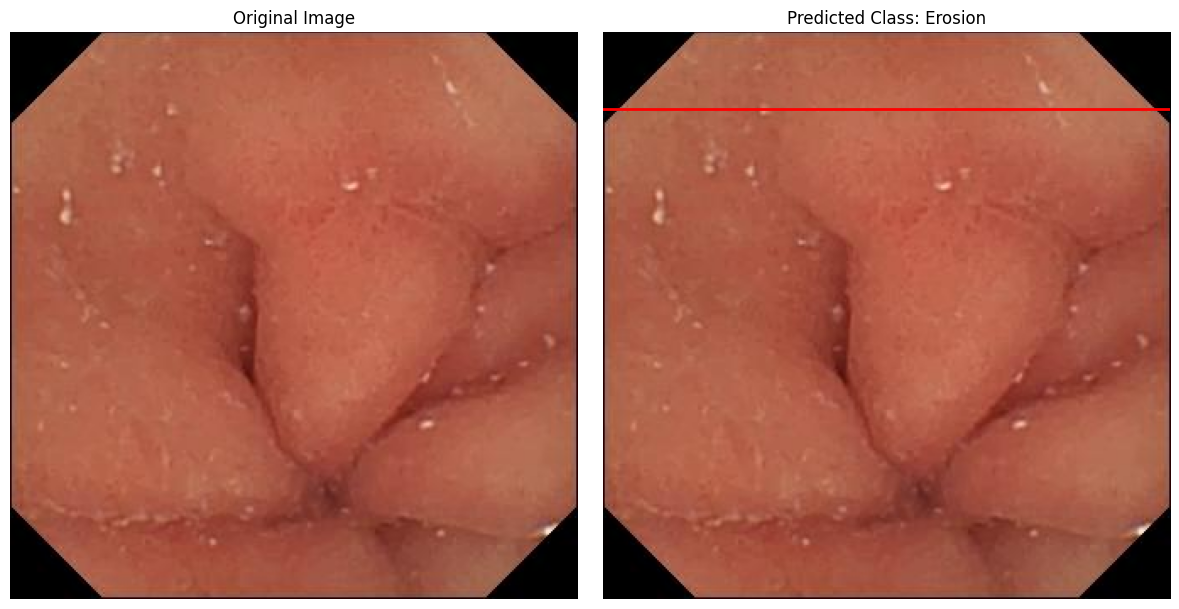

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

w, h = image.size
x1, y1, x2, y2 = bbox

class_label = list(train_dataset.label2idx.keys())[predicted_class]

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(image)
rect = patches.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         linewidth=2, edgecolor='r', facecolor='none')
axs[1].add_patch(rect)
axs[1].set_title(f"Predicted Class: {class_label}")
axs[1].axis("off")

plt.tight_layout()
plt.show()
